# TP RL 3 : DQN

Dans ce TP nous allons nous interesser au Deep Q Networks et leur implémentation pour une tâche classique de RL : le cartpole. Il s'agit d'apprendre à un agent à faire tenir un mât en équilibre sur un véhicule dans une scène 2D. L'agent à deux action possibles : gauche ou droite et reçoit une reward négative lorque le mat tombre de la voiture. Pour cela, nous allons utiliser la bibliothèque gym proposant toute sortes d'environnements et de benchmarks. La reward est proportionnelle au temps de l'épisode.

Commençons par charger quelques utilitaires

Risque de ne pas marcher sur jupyterhub --> Passer sur ce colab ou en local en installant les paquets suivants 


In [ ]:
! pip install gym==0.26.2
! apt-get install xvfb # ne marche pas sur jupyterhub 
! pip install gym-notebook-wrapper 

In [1]:
import gnwrapper
import gym

## Initialisation de l'environnement et première visualisation (optionnel si vous n'utilisez pas JupyterHub)

In [2]:
env = gym.make('CartPole-v1')

In [ ]:

env = gnwrapper.LoopAnimation(gym.make('CartPole-v1', render_mode="rgb_array"))

obs = env.reset()

for _ in range(100):
    next_obs, reward, term, trunc, info = env.step(env.action_space.sample())
    env.render()

    obs = next_obs
    if term or trunc:
        obs = env.reset()

env.display()

### Chargement des librairies

In [ ]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym

In [5]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## DQN Model 

Pour commencer nous allons construire notre réseaux chargé d'approcher la fonction de valeur état-action $Q(s,a)$.

### Coding task

Compléter le code et implémenter le DQN suivant:

* deux couches linéaires de dimensions (in_channels x 128), (128 x 128) 
* Une couche linéaire de taille (128 x action_space)
* Activation ReLU après chaque couche sauf la dernière

In [6]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
         # Coder ici
         # Coder ici
         # Coder ici


    def forward(self, x):
        x = # ...
        x = # ...
        return # ...

Nous utiliserons la mémoire des expériences pour entraîner notre DQN. Elle stocke les transitions que l'agent observe, ce qui nous permet de réutiliser ces données ultérieurement. En échantillonnant de manière aléatoire dans cette mémoire, les transitions qui constituent un lot sont décorrelées. Il a été démontré que cela stabilise grandement et améliore la procédure d'entraînement du DQN

In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [10]:
# BATCH_SIZE est le nombre de transitions échantillonnées depuis le tampon (buffer) de rejeu
# GAMMA est le facteur d'actualisation comme mentionné dans la section précédente
# EPS_START est la valeur initiale d'epsilon
# EPS_END est la valeur finale d'epsilon
# EPS_DECAY contrôle le taux de décroissance exponentielle d'epsilon, une valeur plus élevée signifie une décroissance plus lente
# TAU est le taux de mise à jour du réseau cible
# LR est le taux d'apprentissage de l'optimiseur ``AdamW``

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Récupère le nombre d'action de l'environnement 
n_actions = env.action_space.n
# Récupère le nombre d'observation
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    # Politique epsilon greedy
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) retournera la plus grande valeur de colonne pour chaque ligne.
            # La deuxième colonne du résultat max est l'indice où l'élément maximum a été
            # trouvé, donc nous choisissons l'action avec la récompense attendue la plus élevée.

            return policy_net(state).max(1)[1].view(1, 1)
    else:
        # exploration
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Prend la moyenne de la durée sur 100 épisodes afin de lisser l'affichage
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

## Entraînement 

### Etape d'optimisation 
### Coding Task 
- La fonction de coût est calculée comme la différence entre les valeurs Q actuelles (calculées par le réseau de politique) et les valeurs Q attendues. C'est la fonction de Bellman qu'on utilise dans QLearning et TD(0).   La fonction de coût utilisée est la SmoothL1Loss, également connue sous le nom de Huber Loss.
- Effectuer la mise à jour des paramètres en remettant les gradients à zéro et en rétropropageant le gradient

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Calculez un masque des états non-finis et concaténez les éléments du batch
    # (un état final aurait été celui après lequel la simulation s'est terminée)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Calculez Q(s_t, a) - le modèle calcule Q(s_t), puis nous sélectionnons les
    # colonnes des actions effectuées. Ce sont les actions qui auraient été effectuées
    # pour chaque état du batch selon policy_net

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Calculez V(s_{t+1}) pour tous les états suivants.
    # Les valeurs attendues des actions pour non_final_next_states sont calculées
    # sur la base du "plus ancien" target_net ; en sélectionnant leur meilleure récompense avec max(1)[0].
    # Ceci est fusionné en fonction du masque, de sorte que nous aurons soit la valeur d'état attendue,
    # soit 0 dans le cas où l'état était final.

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Calculez les valeurs Q attendues
    expected_state_action_values = # ... # Equation de Bellman

    # Calculez la Huber Loss 
    criterion = nn.SmoothL1Loss()
    loss = # ...   # Appel à criterion

    # Optimisation du modèle 
    optimizer.zero_grad()
    loss.backward()

    
    # gradient-clipping pour éviter saturation du gradient
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

### Boucle d'apprentissage 
### Coding Task 
- Stocker les transitions en mémoire 
- Appeler la fonction d'optimisation 

Complete


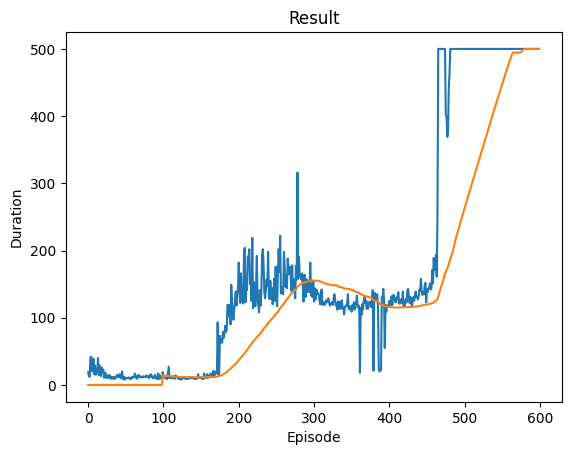

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 400

for i_episode in range(num_episodes):
    # Initialiser l'environnement et récuperer l'état initial
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Stocker les transitions en mémoire 
        # Coder ici

        # Passer à l'état suivant
        state = next_state

        # Une étape d'optimisation du modèle (fonction à appeler)
        # Coder ici

        # Mise à jour soft des poids du réseau cible
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

## Inférence du modèle et visualisation sur CartPole 

### Coding Task 
Maintenant que nous avons entraîné notre modèle, nous allons visualiser les performances de notre DQN sur l'environnement Cartpole en sélectionnant les meilleures actions possibles, c'est-à-dire sans utiliser la stratégie epsilon-greedy.
- Récupérer les q-values prédits par notre modèle en fonction de l'observation courante
- Sélectionner la meilleure action 


In [ ]:
env = gnwrapper.LoopAnimation(gym.make('CartPole-v1', render_mode="rgb_array"))

obs = env.reset()[0]

for _ in range(100):
    observation_tensor = torch.FloatTensor(obs) #Convertir l'observation en tensor
    q_values = # ... # Utiliser policy_net 
    action = torch.argmax(...).item()  # Coder iciChoisir l'action avec la Q-value la plus élevée (torch.argmax)
    next_obs, reward, term, trunc, info = env.step(action)
    env.render()

    obs = next_obs
    if term or trunc:
        obs = env.reset()[0]

env.display()